# Dealing with high dimensional data?
![](https://pbs.twimg.com/media/DfWgx7IV4AAAa0o.jpg)
We will rather visualize it by converting the 14D into 3D and visualize it, neat! 

This notebook describes various techniques used to visualize high dimensional embeddings.

Note: Every formula used in this notebook is taken from the Laurens van der Maaten and Geoffrey Hinton's paper ["Visualizing data using t-SNE"](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) and [SNE](https://www.cs.toronto.edu/~fritz/absps/sne.pdf) by Hinton and Sam Roweis


# Create cluster data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

In [2]:
#Let the higher dimensional data exist in 3D (for visualizing). We will convert this into 2D
cluster1 = np.random.randint(10, 100, (1,3))
cluster2 = np.random.randint(0, 30, (1,3))
#Data points in cluster1 will be near cluster1 (add small random noise). Same is true for cluster 2
#Let's form 20 points each for both cluster
#0 is for cluster 0, 1 is for cluster 1
n = 20
keys = ['d1', 'd2', 'd3', 'label']
data = []
for i in range(n):
    noise = 10*np.random.randn(6)
    c1 = np.append(np.add(cluster1, noise[:3]), 0)
    c2 = np.append(np.add(cluster2, noise[3:]), 1)    
    c1 = dict(zip(keys, c1))
    c2 = dict(zip(keys, c2))
    data.append(c1)
    data.append(c2)
data = pd.DataFrame(data)    

In [3]:
#Normalize
data.d1  = (data-data.d1.mean()) / data.d1.std()
data.d2  = (data-data.d2.mean()) / data.d2.std()
data.d3  = (data-data.d3.mean()) / data.d3.std()

In [4]:
data.head()

,d1,d2,d3,label
0,0.538522,-1.392339,-1.245660,0.0
1,-0.878364,-1.492780,-1.328851,1.0
2,0.994676,-1.360003,-1.218878,0.0
3,-1.385563,-1.528734,-1.358630,1.0
4,1.027861,-1.357651,-1.216929,0.0


# Plot 3d clusters to verify data

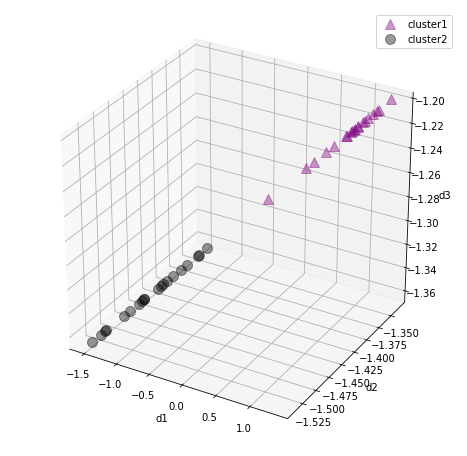

In [5]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(data[data.label==0]['d1'], data[data.label==0]['d2'], data[data.label==0]['d3'], '^', markersize=10, color='purple', alpha=0.4)
ax.plot(data[data.label==1]['d1'], data[data.label==1]['d2'], data[data.label==1]['d3'], 'o', markersize=10, color='black', alpha=0.4)
ax.set_xlabel('d1')
ax.set_ylabel('d2')
ax.set_zlabel('d3')
plt.legend(['cluster1', 'cluster2'])
plt.show()

In [6]:
data.to_csv('utils/cluster_data.csv', index=False)

The above plot shows the clear cluster formation. We now want to convert the 3D data above into 2D while maintaining the cluster information. We will do this using SNE and tSNE

# SNE
Stochastic Neighbour Embedding is a way to convert high dimensional data into low dimensional data in such a way that the neighbours of datapoints in high dimensional space are preserved even in the new low dimensional space. It's like a PCA that preserves neighbourhood information.
Such a technique is very crucial in NLP and since I've used it many times to test my visualize word embeddings, I decided to look into this in much more detail. 

In [7]:
def d(data, i, j, sigma=1/np.sqrt(2)):
    cols = [col for col in data.columns if col!='label']
    x1 = data.iloc[i][cols] 
    x2 = data.iloc[j][cols]
    return np.linalg.norm(
                                x1-x2)**2 / 2*sigma**2

In [12]:
def pji(data, perplexity=5, sigma=5):
    n_samples = data.shape[0]
    Pji = np.zeros((n_samples, n_samples))
    perplexity = 5
    for i in range(n_samples):
        for j in range(n_samples):
            if i==j:
                Pji[i][j] = 0
                continue
            num = np.exp(-d(data, i, j, sigma=sigma))
            den = 0
            neighbours = []
            for k in range(n_samples):
                if k == i : continue
                dist = np.exp(-d(data, i, k, sigma=sigma))   
                neighbours.append(dist)
            neighbours = sorted(neighbours)
            for neighbour in neighbours[:perplexity]:
                den += neighbour
            Pji[j][i] = num/den    
    return Pji        

In [13]:
Pji = pji(data)

In [14]:
#Randomly initialize new space
y = pd.DataFrame(np.random.rand(data.shape[0], 2))
y -= np.mean(y)
y /= np.std(y)

In [15]:
def qji(y, perplexity=5):
    n_samples = y.shape[0]
    Qji = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            if i==j:
                Qji[i][j] = 0
                continue
            num = np.exp(-d(y, i, j))
            den = 0
            for k in range(n_samples):
                if k == i : continue
                dist = np.exp(-d(y, i, k))   
                neighbours.append(dist)
            neighbours = sorted(neighbours)
            for neighbour in neighbours[:perplexity]:
                den += neighbour
            Qji[j][i] = num/den  
    return Qji 

In [34]:
y.shape

(40, 2)

In [35]:
Qji.shape

(40, 40)

In [36]:
Pji.shape

(40, 40)

# Gradient descent to find low dimensional features

In [ ]:
https://www.cs.toronto.edu/~fritz/absps/sne.pdf
    http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
        https://github.com/beaupletga/t-SNE/blob/master/main.py

In [32]:
EPOCHS = 100
lr = 1
n_samples = y.shape[0]
for epoch in range(EPOCHS):
    for i in range(n_samples):
        grad = 0
        for j in range(n_samples):
            grad += (Pji[j][i] - Qji[j][i] + Pji[i][j] - Qji[i][j] )*(y[i]-y[j])  
        grad *= 2
        y[i] -= grad * lr * y[i]
    Qji = qji(y)

KeyError: 2